In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

/Users/anakin./Projects/machine-learning-notebook/Learning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 22.0M/22.0M [00:01<00:00, 18.2MB/s]

Extracting files...


Path to dataset files: /Users/anakin./.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


## 1. Load data

In [6]:
def load_idx_images(path):
    with open(path, 'rb') as f:
        data = f.read()

    # Parse header
    magic, num, rows, cols = np.frombuffer(data[:16], dtype='>i4')
    # The '>i4' means: big-endian, 4-byte integers (MNIST format)

    # Parse image data
    images = np.frombuffer(data[16:], dtype=np.uint8)
    images = images.reshape(num, rows, cols)

    return images

def load_idx_labels(path):
    with open(path, 'rb') as f:
        data = f.read()

    magic, num = np.frombuffer(data[:8], dtype='>i4')
    labels = np.frombuffer(data[8:], dtype=np.uint8)

    return labels


In [33]:
full_test_images = load_idx_images(f"Data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
full_test_labels = load_idx_labels(f"Data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")
full_train_images = load_idx_images(f"Data/train-images-idx3-ubyte/train-images-idx3-ubyte")
full_train_labels = load_idx_labels(f"Data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

In [36]:
print("Training images shape:", full_train_images.shape)
print("Training labels shape:", full_train_labels.shape)
print("Test images shape:", full_test_images.shape)
print("Test labels shape:", full_test_labels.shape)

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


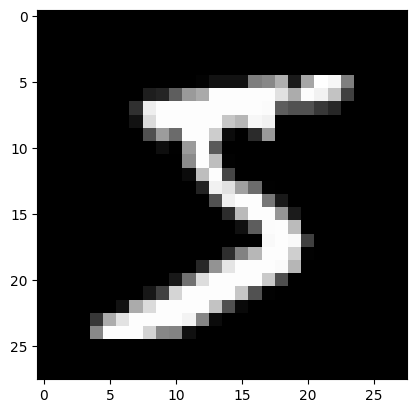

Label: 5
<class 'numpy.ndarray'>


In [37]:
plt.imshow(full_train_images[0], cmap='gray')
plt.show()
print("Label:", full_train_labels[0])
print(type(full_train_images[0]))

## 2. Building the CNN

## CNN Architecture Overview

**Input:** (batch_size, 1, 28, 28)

### Conv Block 1
- Conv2d(1 → 32, kernel=3, padding=1)
- BatchNorm2d(32)
- ReLU
- MaxPool2d(2×2)
**Output:** (batch_size, 32, 14, 14)


### Conv Block 2
- Conv2d(32 → 64, kernel=3, padding=1)
- BatchNorm2d(64)
- ReLU
- MaxPool2d(2×2)
**Output:** (batch_size, 64, 7, 7)


### Flatten
- (batch_size, 64 × 7 × 7) = (batch_size, 3136)


### Fully Connected Layers
- Linear(3136 → 128)
- ReLU
- Linear(128 → 10)
**Output:** (batch_size, 10) — class scores



In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import adam

In [45]:
class clsModel(nn.Module):
    def __init__(self):
        super(clsModel, self).__init__()
        
        layers = []
        
        # Input layers
        layers.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(32))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # -> (32, 14, 14)

        layers.append(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # -> (64, 7, 7)

        layers.append(nn.Flatten())  # -> (64*7*7,)
        layers.append(nn.Linear(in_features=64*7*7, out_features=128))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(in_features=128, out_features=10))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self,x):
        return self.model(x)
        
        
        

## 3. Training the model

In [40]:
from sklearn.model_selection import train_test_split

In [50]:

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

## Turn input to tensor
train_imgs, val_imgs, train_label, val_label = train_test_split(full_train_images, full_train_labels, test_size= 10000/60000, random_state=42)
train_imgs = torch.tensor(train_imgs, dtype=torch.float32).unsqueeze(1).to(device=device) / 255.0
train_label = torch.tensor(train_label).to(device=device)
val_imgs = torch.tensor(val_imgs, dtype=torch.float32).unsqueeze(1).to(device=device) / 255.0
val_label = torch.tensor(val_label).to(device=device)

model = clsModel().to(device=device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

num_epoch = 15
batch_size = 64

for epoch in range(num_epoch):
    
    ## Training
    model.train()
    running_loss = 0.0
    
    for i in range(0, len(train_imgs), batch_size):
        
        batch_input_tensor = train_imgs[i:i+batch_size]
        batch_label_tensor = train_label[i:i+batch_size]
        
        # Compute loss and update gradient
        optimizer.zero_grad()
        output = model(batch_input_tensor)
        loss = F.cross_entropy(output, batch_label_tensor)
        loss.backward()
        optimizer.step()
        
        # Count into total loss
        running_loss += loss.item() * batch_input_tensor.size(0)
    
    ## Validating
    model.eval()    
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(val_imgs), batch_size):
            
            batch_val_input_tensor = val_imgs[i:i+batch_size]
            batch_val_label_tensor = val_label[i:i+batch_size]

            pred = model(batch_val_input_tensor)
            loss = F.cross_entropy(pred, batch_val_label_tensor)
            
            val_loss += loss.item() * batch_val_input_tensor.size(0)
            
    average_training_loss = running_loss / len(train_imgs)
    average_val_loss = val_loss / len(val_imgs)
    
    print(f"Epoch [{epoch+1:02d}/{num_epoch}] | Train: {average_training_loss:.6f} | Val: {average_val_loss:.6f}")
            

    


Epoch [01/15] | Train: 0.131726 | Val: 0.058325
Epoch [02/15] | Train: 0.048580 | Val: 0.044428
Epoch [03/15] | Train: 0.031719 | Val: 0.042438
Epoch [04/15] | Train: 0.023642 | Val: 0.044047
Epoch [05/15] | Train: 0.019535 | Val: 0.045819
Epoch [06/15] | Train: 0.016990 | Val: 0.048127
Epoch [07/15] | Train: 0.016398 | Val: 0.044007
Epoch [08/15] | Train: 0.011803 | Val: 0.047365
Epoch [09/15] | Train: 0.011773 | Val: 0.065294
Epoch [10/15] | Train: 0.010004 | Val: 0.038678
Epoch [11/15] | Train: 0.006838 | Val: 0.048298
Epoch [12/15] | Train: 0.006349 | Val: 0.057246
Epoch [13/15] | Train: 0.009048 | Val: 0.047111
Epoch [14/15] | Train: 0.005980 | Val: 0.060709
Epoch [15/15] | Train: 0.004862 | Val: 0.063778


## 4. Evaluating the model

In [ ]:
test_imgs = torch.tensor(full_test_images, dtype=torch.float32).unsqueeze(1).to(device=device) / 255.0
test_label = torch.tensor(full_test_labels, dtype=torch.long)

In [94]:

def plot_pred(ax,idx):
    ax.imshow(full_test_images[idx], cmap='gray')
    model.eval()
    with torch.no_grad():
        logits = model(test_imgs[idx].unsqueeze(0))
    pred = logits.argmax(dim=1).item()
    ax.set_title(f"Prediction: {pred}")
    ax.axis("off")


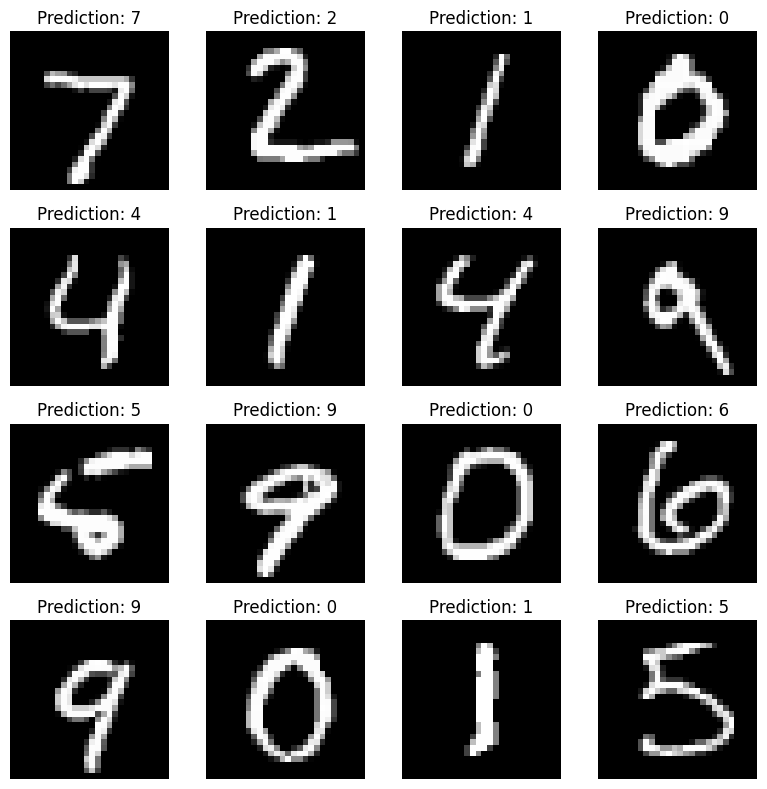

In [95]:
fig, ax = plt.subplots(4,4, figsize=(8,8))
for i, ax in enumerate(ax.flat):
    plot_pred(ax, i)
plt.tight_layout()